In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from poisson_atac.data import load_neurips
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata as ad
import os
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import pyranges as pr
import scipy
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
from joblib import Parallel, delayed

Global seed set to 0


In [3]:
from utils import contigency_table, cell_type_palette, plot_correlation

In [4]:
scv.set_figure_params()

# Load data

In [5]:
fig_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/Figure3'
save_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/biological_analysis'

In [6]:
adata = load_neurips(only_train=False, convert_counts = True)

In [7]:
adata.var.loc[:, ['Chromosome', 'Start', "End"]] = adata.var.index.to_series().str.split('-',expand=True).values

## Compute means per celltype

### Average number of peaks > 1 count

In [8]:
mu_count_hc = np.array([(adata[idx, :].layers['counts']>1).mean(axis=0) for (key, idx) in adata.obs.groupby('cell_type').indices.items()]).squeeze()

In [9]:
mu_count_hc_all = np.array((adata.layers['counts']>1).sum(axis=0)).squeeze()

### Create adatas

In [10]:
obs = pd.DataFrame({'cell_type': adata.obs.groupby('cell_type').indices.keys()}).astype('category')

In [11]:
a_mu_hcounts = ad.AnnData(X=np.array(mu_count_hc), obs=obs, var=adata.var)

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
a_count_hc_all = pd.Series(mu_count_hc_all, index=adata.var_names)

## Get peaks with high counts

In [13]:
threshold = [(0, 0.5), (0.5, 0.75), (0.75, 0.9), (0.9, 0.95), (0.95, 1)]

In [14]:
max_ = a_mu_hcounts.X.max(axis=0)

In [15]:
var_peaks = adata.var
var_peaks['max'] = max_

In [16]:
peaks_sets = {str(thr):
    var_peaks.iloc[
        np.where((var_peaks['max'] > np.quantile(max_, thr[0])) & (var_peaks['max'] <= np.quantile(max_, thr[1])))[0]] 
    for thr in threshold
}

## Load annotation

In [17]:
annotation = pd.read_csv(os.path.join(save_path, 'annotation', 'great_regdom_annotation.csv'), index_col=0)

In [18]:
annotation.index = annotation.Chromosome + '-' + annotation.Start.astype(str) + '-' + annotation.End.astype(str)

# Length distribution of high count peaks

(0, 0.95) vs. (0.95, 1): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.797e-269 U_stat=2.302e+08


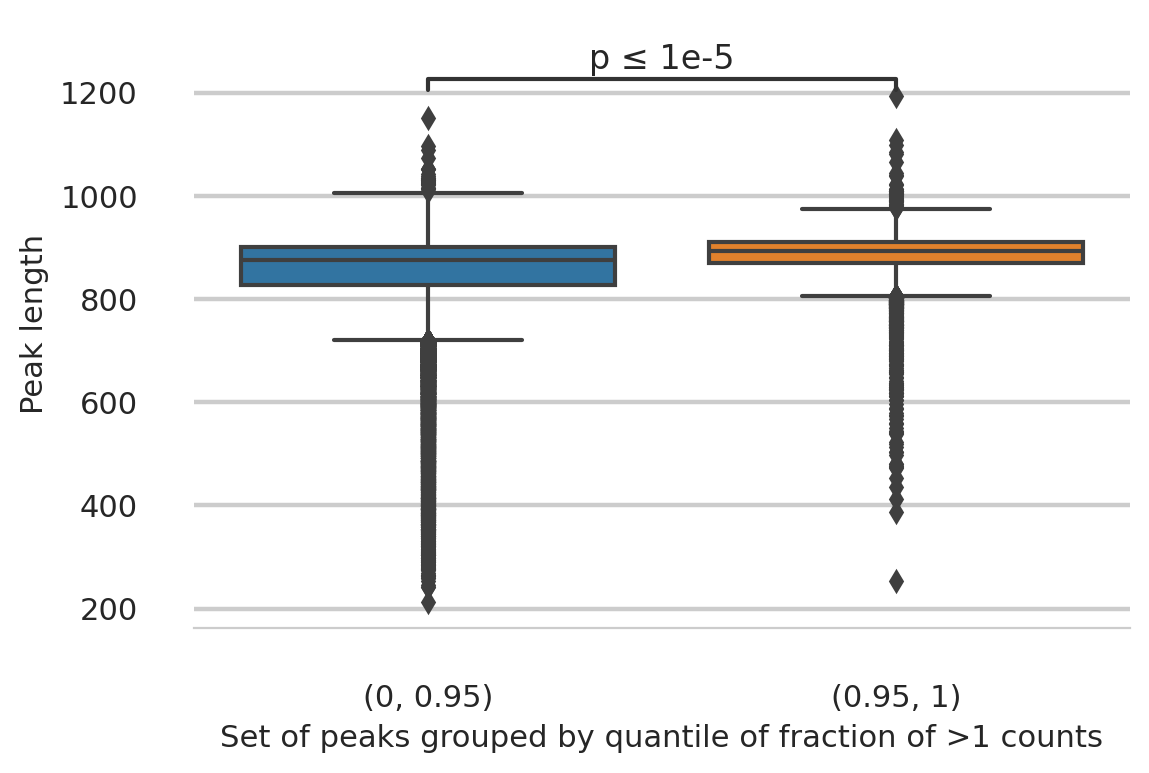

In [19]:
scv.set_figure_params()
sns.set_style("whitegrid")
var_peaks = peaks_sets['(0.95, 1)']
length = var_peaks['End'].astype(int) - var_peaks['Start'].astype(int)
length_others = adata.var[~adata.var.index.isin(var_peaks.index)]
length_others = length_others['End'].astype(int) - length_others['Start'].astype(int)

order = ['(0, 0.95)', '(0.95, 1)']
sns_df = pd.DataFrame({'(0.95, 1)': length, '(0, 0.95)': length_others}).melt(var_name='Peak type', value_name='Peak length')
sns_df = sns_df[sns_df['Peak length'] < 1500] #filter two outliers
ax = sns.boxplot(data=sns_df, x='Peak type', y='Peak length', order=order)

annot = Annotator(ax, [('(0.95, 1)', '(0, 0.95)')], data=sns_df, x='Peak type', y='Peak length', orient="v", order=order)
annot.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False, comparisons_correction="Benjamini-Hochberg", verbose=2)
annot.apply_test()
ax, test_results = annot.annotate(line_offset=0, line_offset_to_group=0)
ax.set(xlabel='Set of peaks grouped by quantile of fraction of >1 counts')
sns.despine(left=True)

#plt.savefig(os.path.join(fig_path, 'length_distribution.png'))
#plt.savefig(os.path.join(fig_path, 'length_distribution.pdf'))

# Overlap analysis

## Get superenhancers

In [20]:
sedb = [pd.read_csv(os.path.join(save_path, 'annotation', 'Human_Bone_marrow_hg38', file), sep='\t') for file in os.listdir(os.path.join(save_path, 'annotation', 'Human_Bone_marrow_hg38'))] 

In [21]:
sedb = pd.concat(sedb)

In [22]:
sedb = sedb.rename({'se_chr': 'Chromosome', 'se_start': 'Start', 'se_end':'End'}, axis=1)

In [23]:
sedb = pr.PyRanges(sedb)

In [24]:
sedb = sedb.overlap(pr.PyRanges(adata.var))

## Get highly expressed genes

In [25]:
gex_data_path = os.path.join('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data', 'neurips', 'phase2-private-data/common/openproblems_bmmc_multiome_phase2', 'openproblems_bmmc_multiome_phase2.manual_formatting.output_rna.h5ad')

In [26]:
adata_gex = ad.read(gex_data_path)

In [27]:
top_n = 2000
highly_expressed_genes = adata_gex.var_names[np.argsort(adata_gex.X.mean(axis=0).A.squeeze())[-top_n:]]

In [28]:
he_regions = annotation[annotation.gene.isin(highly_expressed_genes)& (annotation.peak_type=='promoter') ] #

## Get highly variable genes

In [ ]:
sc.pp.highly_variable_genes(adata_gex, batch_key='batch', n_top_genes=2000)

In [30]:
hv_genes = adata_gex.var_names[adata_gex.var.highly_variable]

In [31]:
hv_regions = annotation[annotation.gene.isin(hv_genes)& (annotation.peak_type=='promoter') ]

## Get distal elements

In [32]:
filter_ = ['dELS,CTCF-bound', 'dELS']

In [33]:
dist_ele = pd.read_csv(os.path.join(save_path, 'annotation', 'GRCh38-cCREs.bed'), sep='\t', header=None, names=['Chromosome', 'Start', 'End', 'Name1', 'Name2', 'Type'])

In [34]:
dist_ele = dist_ele[dist_ele.Type.isin(filter_)]

In [35]:
dist_ele = pr.PyRanges(dist_ele)

In [36]:
dist_ele = dist_ele.overlap(pr.PyRanges(adata.var))

## Overlap analysis

In [37]:
grs = ({'Distal regulatory elements': dist_ele, 'Super enhancers': sedb, 'Promoters of\nhighly variable genes (from RNA)': pr.PyRanges(hv_regions), 'Promoters of\nhighly expressed genes (from RNA)': pr.PyRanges(he_regions)})

In [38]:
overlap = (pr.count_overlaps(grs, pr.PyRanges(adata.var)).df.loc[:, list(grs.keys())]>0)*1

In [39]:
enrich = []
pval = []
for key, peak_set in peaks_sets.items():
    enrichment = {anno: scipy.stats.fisher_exact(contigency_table(grs, peak_set, M=overlap.shape[0], n = overlap[anno].sum(), anno=anno), alternative='greater')[0] for anno in list(grs.keys())}
    pvalue = {anno: scipy.stats.fisher_exact(contigency_table(grs, peak_set, M=overlap.shape[0], n = overlap[anno].sum(), anno=anno), alternative='greater')[1] for anno in list(grs.keys())}
    enrich.append(pd.DataFrame(enrichment, index=[key]))
    pval.append(pd.DataFrame(pvalue, index=[key]))

In [40]:
pval = pd.concat(pval)

In [41]:
pval = pval.melt(ignore_index=False).reset_index()

In [42]:
#adjust pvalue
pval['pval_adj'] = multipletests(pval['value'], method='fdr_bh', alpha=0.05)[1]

## Plot results

In [43]:
pval['variable'] = pd.Categorical(pval.variable, categories=grs.keys())

In [44]:
pval = pval.sort_values(['variable', 'index'])

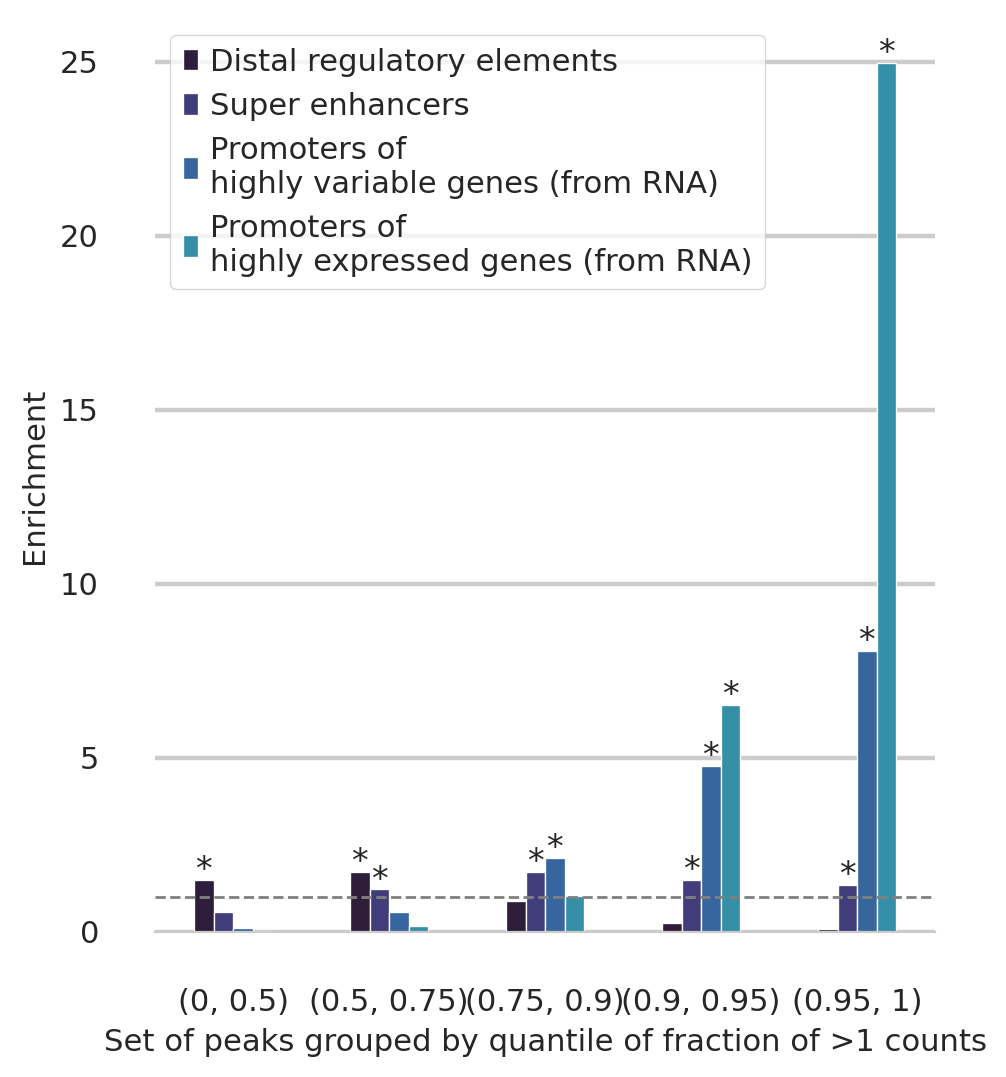

In [45]:
scv.set_figure_params()
sns.set_style("whitegrid")
with sns.color_palette("mako"):
    fig, ax = plt.subplots(figsize=(5,6))
    barplot = pd.concat(enrich).plot(kind='bar', ax = ax)
    for p, sig in zip(barplot.patches, pval['pval_adj']):
        if sig <=0.05:
            barplot.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                         '*', ha='center')
    
    plt.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.xticks(rotation=0)
    plt.ylabel('Enrichment')
    plt.xlabel('Set of peaks grouped by quantile of fraction of >1 counts')
    
    sns.despine(left=True)
    ax.xaxis.grid(False)
    #plt.savefig(os.path.join(fig_path, 'enrichment_high_peaks.png'), bbox_inches= "tight")
    #plt.savefig(os.path.join(fig_path, 'enrichment_high_peaks.pdf'), bbox_inches= "tight")

In [46]:
def compute_statistics(overlap_p, overlap_b):
    k = overlap_p['k']
    n = overlap_p['n']
    p = overlap_b['k']/overlap_b['n']
    pval = scipy.stats.binomtest(k=k, n=n, p=p, alternative='greater').pvalue
    return {'Binary': p, 'Poisson': k/n, 'pval': pval}

In [47]:
peak_sets_poisson = {cell_type: rank_bayes_factor(vae_poisson_all, cell_type, top=1000) for cell_type in cell_types}
peak_sets_binary = {cell_type: rank_bayes_factor(vae_binary_all, cell_type, top=1000) for cell_type in cell_types}

overlap_poisson = {cell_type: compute_deg_overlap(peak_sets_poisson[cell_type], annotation, deg.loc[cell_type].names, merge=False) for cell_type in cell_types}   
overlap_binary = {cell_type: compute_deg_overlap(peak_sets_binary[cell_type], annotation, deg.loc[cell_type].names, merge=False) for cell_type in cell_types}

NameError: name 'cell_types' is not defined

In [ ]:
sns_df = pd.DataFrame({cell_type: compute_statistics(overlap_poisson[cell_type], overlap_binary[cell_type]) for cell_type in cell_types}).T
sns_df.index.name = 'cell_type'

In [ ]:
annotate = sns_df.loc[sns_df.pval < 0.1].index #['Normoblast', 'ID2-hi myeloid prog']

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(data=sns_df.reset_index(), x='Binary', y='Poisson', hue='cell_type', palette=dict(zip(adata.obs.cell_type.cat.categories,adata.uns['cell_type_colors'])), ax=ax)
plt.axline((0,0), (0.1,0.1), color='gray', linestyle='--', linewidth=1)
plt.title('Proportion of promoters of upregulated DE genes\n that are in top 1000 DA peaks', fontsize=10)

for s in annotate:
    ax.text(x=sns_df.loc[sns_df.index == s, 'Binary'].values, y=sns_df.loc[sns_df.index == s, 'Poisson'].values + 0.005, s=sns_df.loc[sns_df.index == s, 'pval'][0]), ha='center', va='bottom', fontsize=10)
g.legend().remove()
plt.tight_layout()
plt.xlim((0, 0.25))
plt.ylim((0, 0.25))
plt.xlabel('Proportion - Binary', fontsize=10)
plt.ylabel('Proportion - Poisson', fontsize=10)
plt.savefig(os.path.join(fig_path, 'correlation_DEGs.png'))
plt.savefig(os.path.join(fig_path, 'correlation_DEGs.pdf'))


# Correlate gene expression with accessibility

## Restrict high count peaks to promoters

In [ ]:
promoter = annotation[(annotation.peak_type == 'promoter') & annotation.gene.isin(adata_gex.var_names)]

In [ ]:
test_regions = peaks_sets['(0.95, 1)'][peaks_sets['(0.95, 1)'].index.isin(promoter.index)]

In [ ]:
test_regions =  test_regions.join(promoter, rsuffix='promoter')

## Restrict adata to similar size factor

In [ ]:
quant = adata.obs.size_factor.quantile([0.25, 0.75])
cell_restriction = adata.obs.size_factor.between(quant[0.25], quant[0.75])

In [ ]:
sns.set_style('white')
g = sns.kdeplot(data=adata.obs, hue='cell_type', x='size_factor', common_norm=False, palette=cell_type_palette)
g.legend().remove()
plt.axvline(quant[0.25], color='gray', linestyle='--', linewidth=1)
plt.axvline(quant[0.75], color='gray', linestyle='--', linewidth=1)
plt.xlabel('Total number of fragments')
plt.savefig(os.path.join(fig_path, 'fragment_size_distribution.pdf'))
plt.savefig(os.path.join(fig_path, 'fragment_size_distribution.png'))

## Compute correlation

In [74]:
def compute_corr(adata, adata_gex, region, gene):
    non_zero_cells = adata.obs_names[(adata[:, region].layers['counts'] > 0).A.squeeze()] 
    return scipy.stats.spearmanr(adata[non_zero_cells, region].layers['counts'].A.squeeze(),adata_gex[non_zero_cells, gene].layers['counts'].A.squeeze())  

In [ ]:
corr = Parallel(n_jobs=-1)(
    delayed(compute_corr)(
        adata=adata[cell_restriction],
        adata_gex=adata_gex[cell_restriction],
        region=region,
        gene=df.gene
    ) 
    for region, df in tqdm(test_regions.iterrows()) #
)

In [223]:
test_regions['correlation'] = corr['correlation'].values
test_regions['pvalue'] = corr['pvalue'].values

In [243]:
sort = test_regions.sort_values('pvalue', ascending=True).reset_index().groupby(['index']).first()

In [244]:
sort.to_csv(os.path.join(save_path, 'correlations_size_factor_subset.csv'))

# Plot highly correlated regions

In [49]:
test_regions = pd.read_csv(os.path.join(save_path, 'correlations_size_factor_subset.csv'), index_col=0)

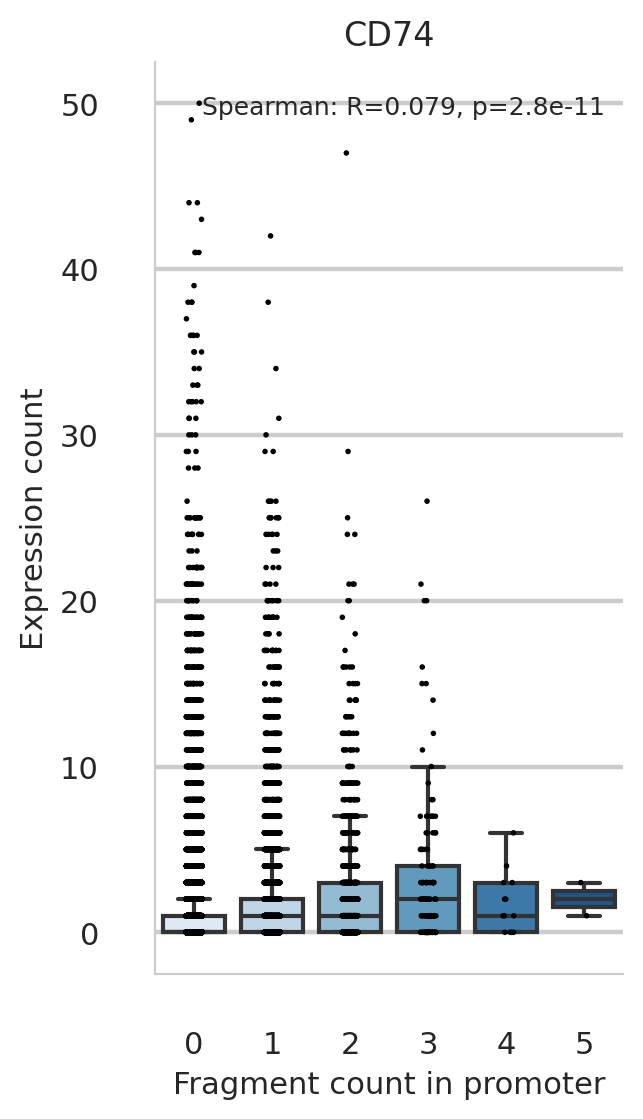

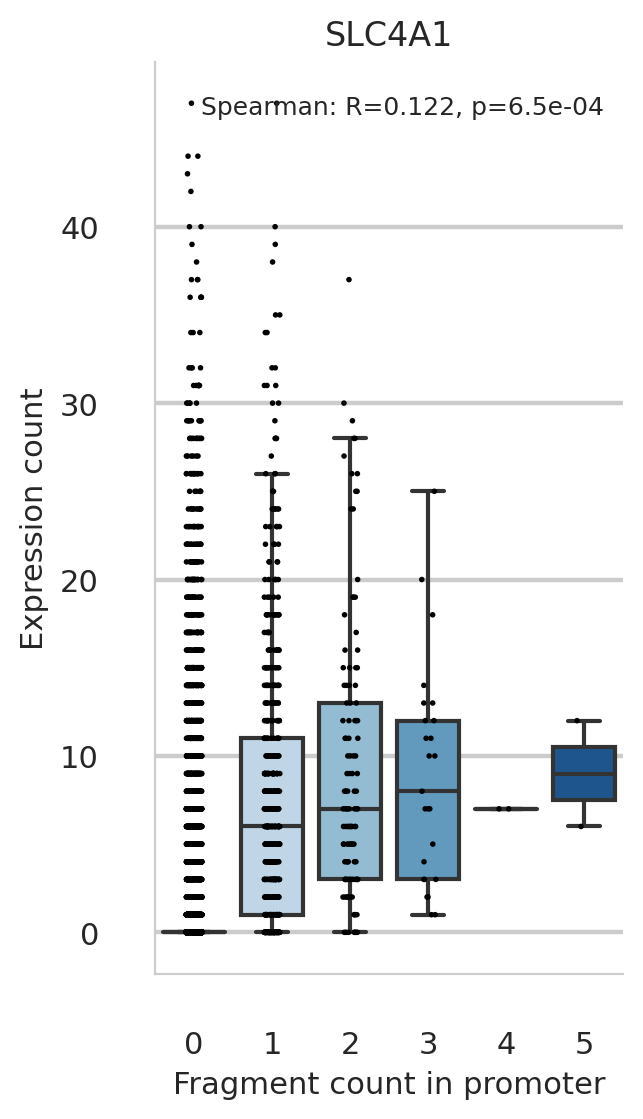

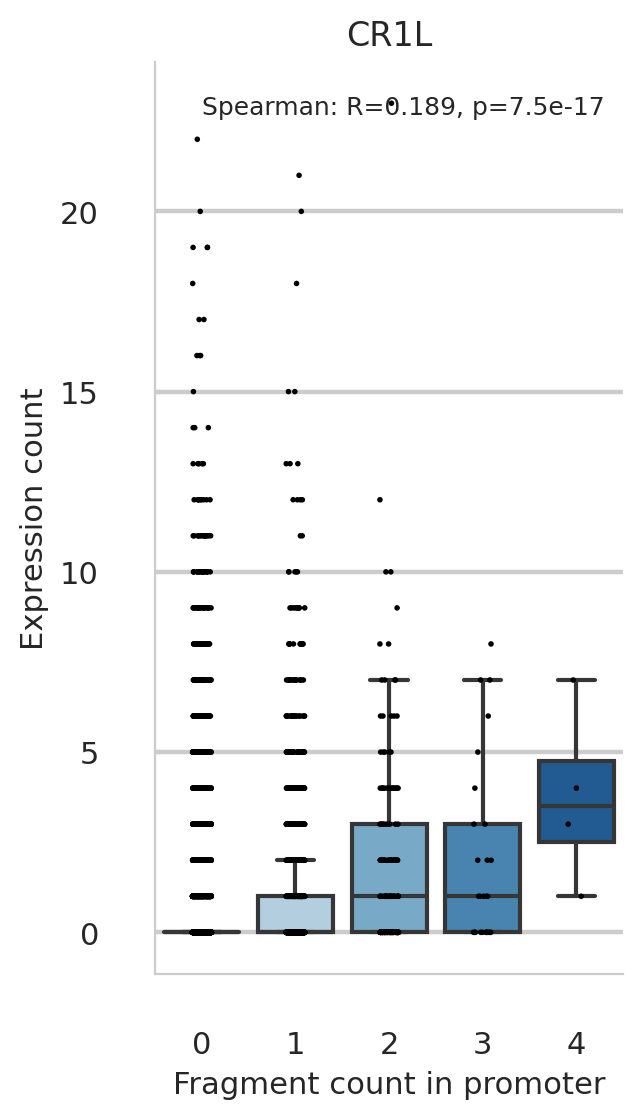

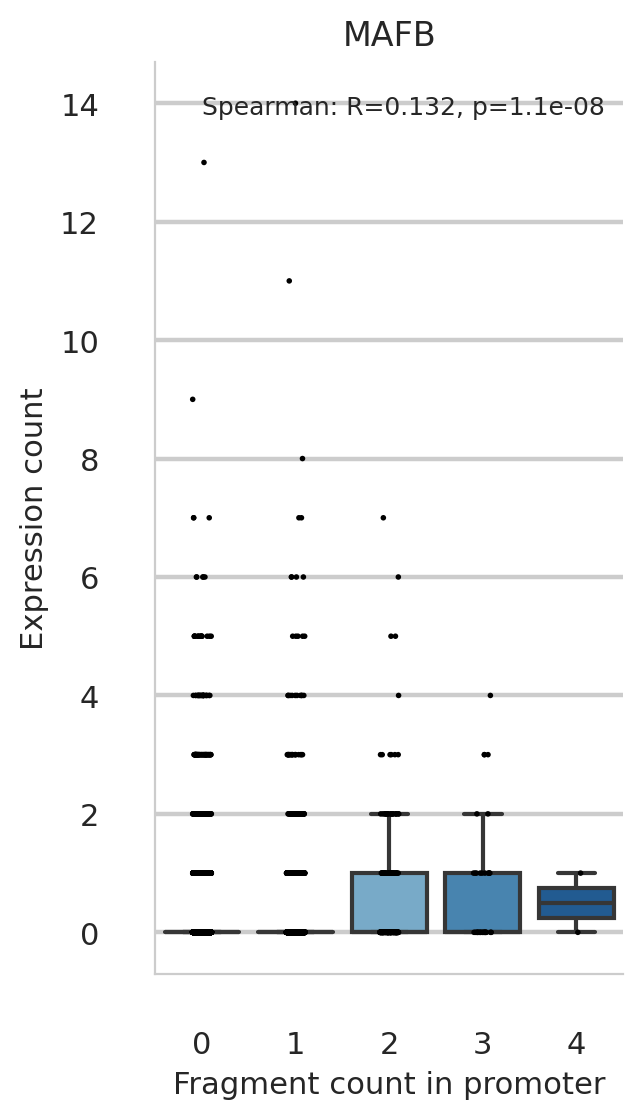

In [51]:
for gene in ['CD74', 'SLC4A1', 'CR1L', 'MAFB']:
    plot_correlation(test_regions, adata, adata_gex, gene, fig_path=fig_path)

In [56]:
scipy.stats.wilcoxon(test_regions.correlation, y=np.zeros(test_regions.shape[0]), alternative='greater')

WilcoxonResult(statistic=3954870.0, pvalue=0.002926130260736238)